## Lab 3 - Radio Interferometry at X-Band

In [48]:
import ugradio
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [57]:
def combine_channels(data, num_channels, nsamples):
    smooth_data_median = np.zeros(nsamples/num_channels)
    smooth_data_average = np.zeros(nsamples/num_channels)

    for i in range(len(data)/num_channels):
        smooth_data_median[i] = np.median(data[num_channels*i:num_channels*(i+1)])
        smooth_data_average[i] = np.average(data[num_channels*i:num_channels*(i+1)])
    return smooth_data_median, smooth_data_average

def getPowerSpectra(input_voltage, t_samp):
    fourier = np.fft.fft(input_voltage)
    freqs = np.fft.fftfreq(len(fourier), t_samp)
    power = np.abs(fourier) ** 2

    return np.fft.fftshift(power), np.fft.fftshift(freqs)

def getFFT(input_voltage, v_samp):
    fourier = np.fft.fft(scaleToReal(input_voltage))
    freqs = np.fft.fftfreq(len(fourier), 1 / (v_samp)) 
    return fourier, freqs

def split_file_dual(filename, blocks = 50, divisor = 1, samples = 16000, volt_range = [-0.2, 0.2]):
    split_into_blocks = np.load(filename)[:2*samples]
    print(len(split_into_blocks))
    split_into_blocks.shape = (blocks*2, samples)

    split_complex = np.zeros((blocks, samples), dtype=np.complex)
    
    v_samp = 62.5e6/divisor
    
    for i in range(len(split_complex)):
        real = scaleToReal(split_into_blocks[i], volt_range)
        imag = scaleToReal(split_into_blocks[i + blocks], volt_range)

        split_complex[i] = real + np.multiply(1j, imag)
    return split_complex

def sub_3row(powers, freqs, titles, positive = True):
    fig, axes = plt.subplots(3)
    fig.set_figheight(30)
    fig.set_figwidth(20)
    i = 0
    for freq, power, title in zip(freqs, powers, titles):
        if positive: 
            axes[i].plot(freq[(len(crab_freqs)/2 + 10):], power[(len(crab_freqs)/2 + 10):])
            axes[i].set_xlim(0,0.5)
        axes[i].set_xlabel("Frequency ($Hz$)", fontsize = 30)
        axes[i].set_ylabel("Power ($(V \cdot s)^2$", fontsize = 30)
        axes[i].tick_params(labelsize=20)
        axes[i].set_title(title, fontsize = 30)
        i += 1
    fig.tight_layout()
    
def window(timeData, funcWindow, chunks):
    timeDataSplit = np.array_split(timeData, chunks)
    windowData = []
    for split in timeDataSplit:
        timeWindow = np.multiply(split, funcWindow(len(split)))
        windowData.extend(timeWindow)
    windowData = np.array(windowData)
    return windowData   

In [85]:
data = r"/Users/sabrinaberger/3lab121/Fourier_Entertainment/"

# separating data into voltage (Volts) and time (unix time)
crab = np.load(data + "CrabDataR40.npz")
crabV = crab["arr_1"]
crabTimes = crab["arr_0"]
crabT = ( crabTimes[len(crabTimes)-1] - crabTimes[0] ) / len(crabTimes)

moon = np.load(data + "MoonData38.npz")
moonV = moon["arr_1"]
moonT = ( moon["arr_0"][len(moon["arr_0"])-1] - moon["arr_0"][0] ) / len(moon["arr_0"])

sun = np.load(data + "SunDataR51.npz")
sunV = sun["arr_1"]
sunTimes = sun["arr_0"]
sunT = (sunTimes[len(sunTimes)-1] - sunTimes[0]) / len(sunTimes)

## Initial Data Visualization Plots

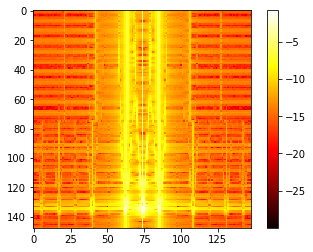

In [86]:
sunV = window(sunV, np.bartlett, 2190)
sun_reshape = np.array(sunV[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)

plt.imshow((np.log(np.abs(sun_fft_two_d)**2)), cmap="hot")
plt.colorbar()
plt.figure()

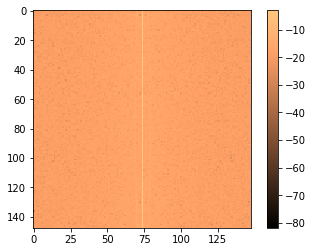

In [76]:
crab_reshape = np.array(crabV[:21904]).reshape((148,148))
crab_fft_two_d = np.fft.fftshift(np.fft.fft(crab_reshape), axes = 1)

plt.imshow((np.log(np.abs(crab_fft_two_d)**2)), cmap="copper")
plt.colorbar()
plt.figure()

In [54]:
crab_power, crab_freqs = getPowerSpectra(crabV[:512], crabT)

In [58]:
moon_power, moon_freqs = getPowerSpectra(moonV[:512], moonT)

In [59]:
sun_power, sun_freqs = getPowerSpectra(sunV[:512], sunT)

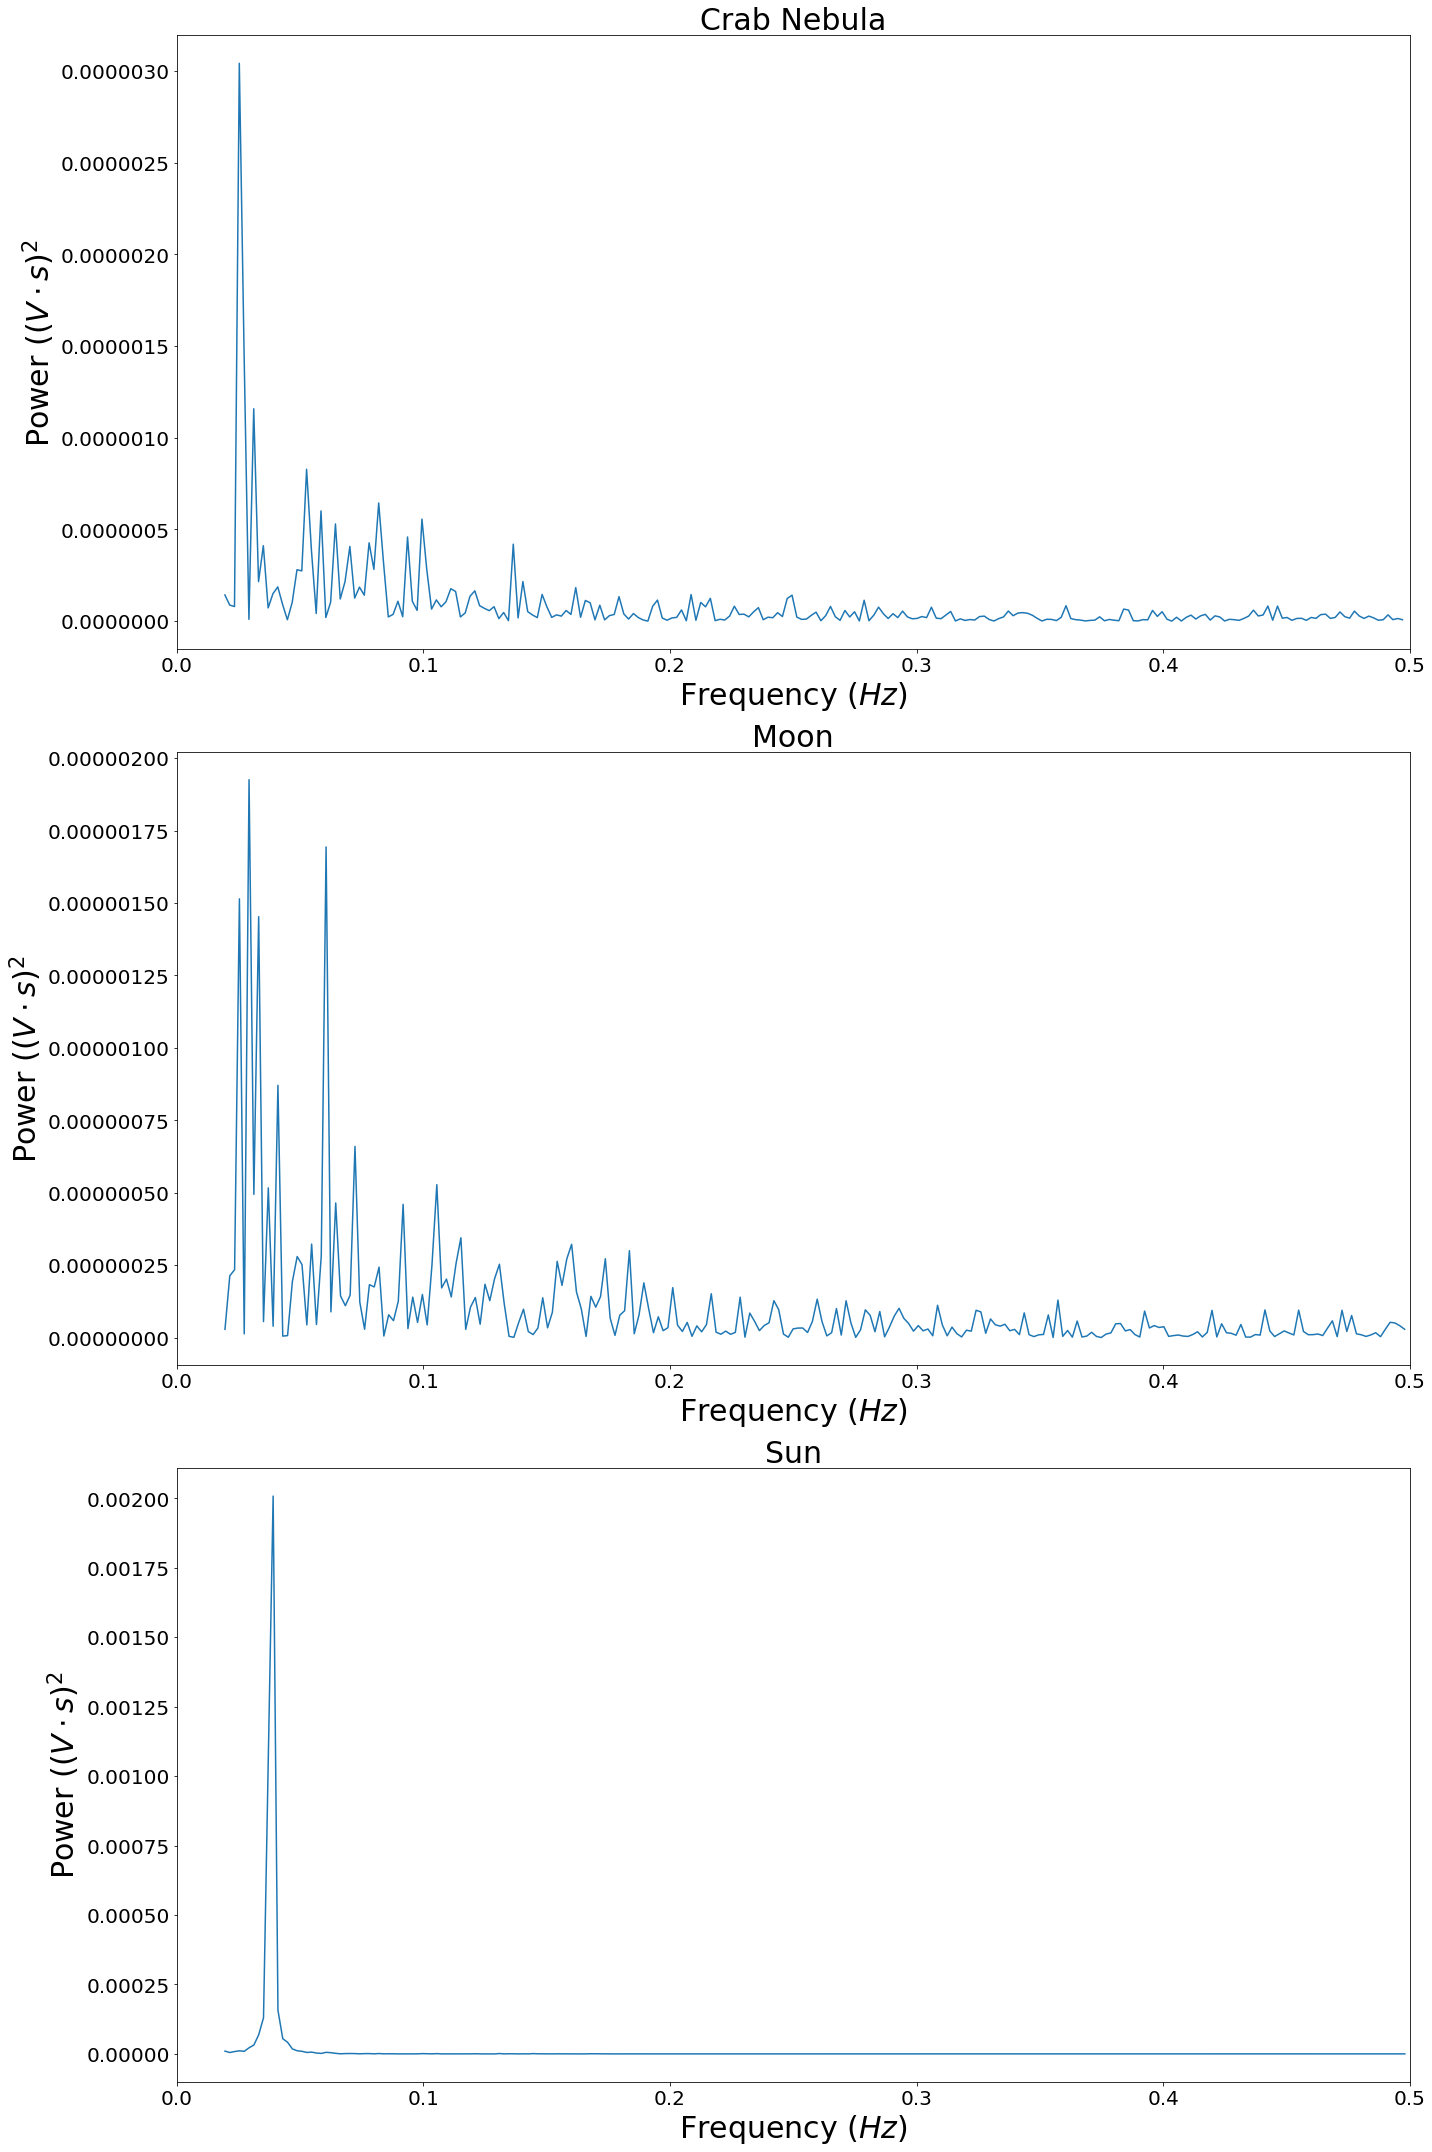

In [60]:
sub_3row([crab_power, moon_power, sun_power], [crab_freqs, moon_freqs, sun_freqs], ["Crab Nebula", "Moon", "Sun"])

## Fourier Filtering

In [49]:
testWindow = window(np.ones(100), np.hamming, 10)
sunWindowed = window(sunV, np.hamming, 1000)
print(testWindow)


test = np.hamming(len(testWindow))


[0.08       0.18761956 0.46012184 0.77       0.97225861 0.97225861
 0.77       0.46012184 0.18761956 0.08       0.08       0.18761956
 0.46012184 0.77       0.97225861 0.97225861 0.77       0.46012184
 0.18761956 0.08       0.08       0.18761956 0.46012184 0.77
 0.97225861 0.97225861 0.77       0.46012184 0.18761956 0.08
 0.08       0.18761956 0.46012184 0.77       0.97225861 0.97225861
 0.77       0.46012184 0.18761956 0.08       0.08       0.18761956
 0.46012184 0.77       0.97225861 0.97225861 0.77       0.46012184
 0.18761956 0.08       0.08       0.18761956 0.46012184 0.77
 0.97225861 0.97225861 0.77       0.46012184 0.18761956 0.08
 0.08       0.18761956 0.46012184 0.77       0.97225861 0.97225861
 0.77       0.46012184 0.18761956 0.08       0.08       0.18761956
 0.46012184 0.77       0.97225861 0.97225861 0.77       0.46012184
 0.18761956 0.08       0.08       0.18761956 0.46012184 0.77
 0.97225861 0.97225861 0.77       0.46012184 0.18761956 0.08
 0.08       0.18761956 0.460121

In [ ]:
def ideal_fringe_freq(data, dec, spacing):
    f_f_ideal = []
    LST = []
    for i in range(len(data["arr_0"])/spacing):
        currentLST = ugradio.timing.lst(ugradio.timing.julian_date(data["arr_0"][i*spacing]))
        LST.append(currentLST)
        ra = 1.46
        h = currentLST - ra
        f_f_ideal.append(0.037*np.cos(dec)*np.cos(h))
    return LST, f_f_ideal


def fringes(arr, spacing, ra):
    time = arr["arr_0"]
    volts = arr["arr_1"]
    
    t_samp = (time[-1] - time[0])/len(time)
    
    f_f = []
    hours = []
    lst = []
    
    for i in range(len(time)/spacing):
        time_chunk = time[i*spacing:(i+1)*spacing] 
        
        chunk = volts[i*spacing:(i+1)*spacing] 
        chunk_avg = np.mean(chunk)
        
        voltage = np.fft.fft(chunk - chunk_avg)                
        freqs = np.fft.fftfreq(len(voltage), t_samp)
        power = np.abs(voltage)**2
           
        freqsH = np.fft.fftshift(freqs)
        powerH = np.fft.fftshift(power)
          
        max_elem = np.argmax(powerH[len(power)/2:])
        f_f.append(freqsH[len(powerH)/2:][max_elem])
        
        currentLST = ugradio.timing.lst(ugradio.timing.julian_date(np.median(time_chunk)))
        hour = currentLST - ra

        hours.append(hour)
        lst.append(currentLST)
      
    return hours, f_f, lst

In [ ]:
crab_coord = SkyCoord(l = 184.5575*u.degree, b = -5.7844*u.degree, frame = 'galactic')
crab_coord = crab_coord.fk5

s_squared = []

crab_data = np.load(data + "CrabDataR40.npz")

crab_ra, crab_dec = crab_coord.ra.rad, crab_coord.dec.rad


possible_bew = np.linspace(10, 30)

hours, actual_crab_fringes, lst = fringes(crab_data, 1024, crab_ra)

possible_qew = (possible_bew/2.77e-2) 

def ideal_fringe_freq(data, dec, spacing, qew):
    f_f_ideal = []
    LST = []
    for i in range(len(data["arr_0"])/spacing):
        currentLST = ugradio.timing.lst(ugradio.timing.julian_date(data["arr_0"][i*spacing]))
        LST.append(currentLST)
        ra = 1.46
        h = currentLST - ra
        factor = (2*np.pi)/(3600*24)
        f_f_ideal.append(factor*qew*np.cos(dec)*np.cos(h))
    return LST, f_f_ideal

for qew in possible_qew: 
    LST, calculated_crab_fringes = ideal_fringe_freq(crab_data, crab_dec, 1024, qew)
    res = np.asarray(calculated_crab_fringes) - actual_crab_fringes
    
    plt.plot(LST, calculated_crab_fringes)
    plt.plot(LST, actual_crab_fringes)
    plt.xlabel("LST")
    plt.ylabel("Fringe Frequency (Hz)")
    
    
    S = np.sum(res)
    s_squared.append(S**2)

plt.plot(LST, calculated_crab_fringes)
plt.plot(LST, actual_crab_fringes, label = "Actual Crab fringes")
       
plt.legend()




In [ ]:
sunV = window(sunV, np.hamming, 7)
sunPower, sunFreqs = getPowerSpectra(sunV, sunT)
sun_reshape = np.array(sunV).reshape((148,148))


plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()


# sunV2 = np.multiply(sunV, np.hamming(len(sunV)))
# sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
# sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
# plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
# plt.colorbar()
# plt.figure()


# sunV2 = np.multiply(sunV, np.bartlett(len(sunV)))
# sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
# sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
# plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
# plt.colorbar()
# plt.figure()


# sunV2 = np.multiply(sunV, np.blackman(len(sunV)))
# sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
# sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
# plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
# plt.colorbar()
# plt.figure()


# sunV2 = np.multiply(sunV, np.hanning(len(sunV)))
# sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
# sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
# plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
# plt.colorbar()
# plt.figure()


# sunV2 = np.multiply(sunV, np.kaiser(1,len(sunV)))
# sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
# sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
# plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
# plt.colorbar()
# plt.figure()